# Equity Options Portfolio Optimization:
**Authors:** William Lester, Luke Rutherford, Dylan Kynoch, Henry Daniel \
**Start Date:** 4/17/2024 \
**Last Updated:** 4/19/2024

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import Data_Functions as dat_func, Visualizations as vis
import yfinance as yf
from datetime import datetime
import QuantLib as ql
from scipy.optimize import minimize
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
start_date,end_date="2023-04-19",'2024-04-19'
start_date,end_date=pd.to_datetime(start_date),pd.to_datetime(end_date)
trade_dates=dat_func.get_trading_days(start_date,end_date)

tickers = ['XOM', 'WMT', 'GPC', 'OXY', 'PM', 'FI', 'ATKR', 'VICI', 'ADBE', 'AMAT', 'STLD']
ex_stock='XOM'

[*********************100%%**********************]  11 of 11 completed


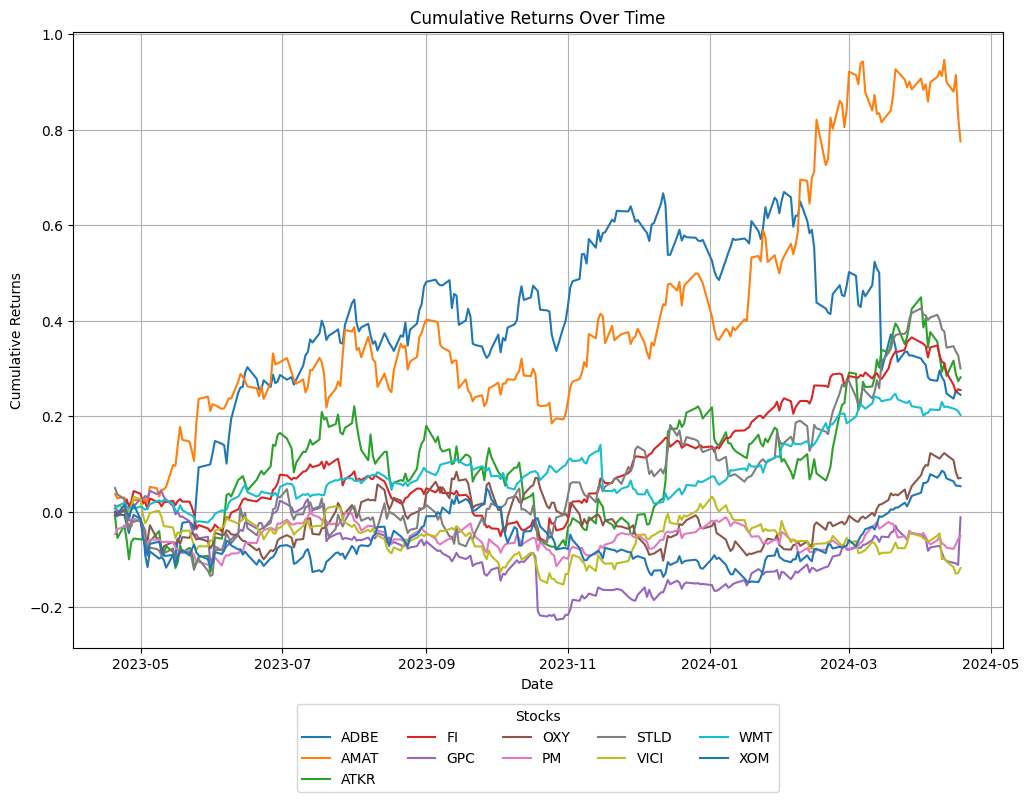

In [3]:
stock_df=dat_func.get_price_df(tickers,start_date,end_date)
returns_df=dat_func.get_log_returns(stock_df)
vis.plot_cumulative_returns(returns_df)

In [4]:
fred,poly=dat_func.connect_apis()
risk_free_rate=fred.get_series('GS10').iloc[-1]/100

In [5]:
init_weights,init_ret,init_std=dat_func.get_init_port(returns_df,risk_free_rate,leverage_limit=1)
init_weights=init_weights.round(3)
print('Initial Port Returns:',init_ret)
print('Initial Port Volatility:',init_std)
print('Initial Port Sharpe:',(init_ret-risk_free_rate)/init_std)
print('Optimal Weights:',dict(zip(returns_df.columns,init_weights)))

Initial Port Returns: 0.234082602028352
Initial Port Volatility: 0.08587228928657131
Initial Port Sharpe: 2.2356758346999626
Optimal Weights: {'ADBE': -0.0, 'AMAT': 0.162, 'ATKR': 0.0, 'FI': 0.279, 'GPC': -0.037, 'OXY': 0.0, 'PM': -0.053, 'STLD': 0.021, 'VICI': -0.225, 'WMT': 0.213, 'XOM': 0.01}


## Initial Portfolio Simulation:
### Geometric Brownian Motion: 

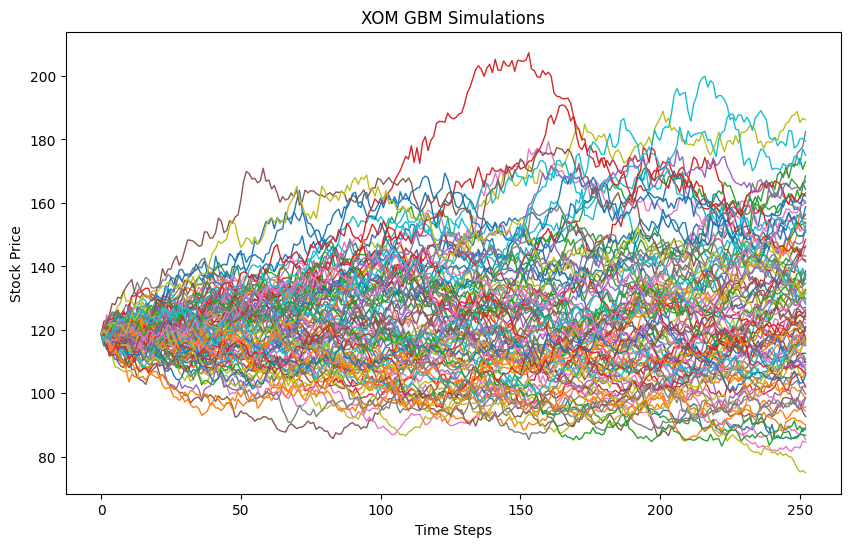

In [6]:
gpc_gbm=dat_func.simulate_gbm(stock_df[ex_stock][-1],returns_df.mean()[ex_stock]*252,returns_df.std()[ex_stock]*np.sqrt(252),1,N=100)
vis.plot_paths(gpc_gbm,f'{ex_stock} GBM',False)

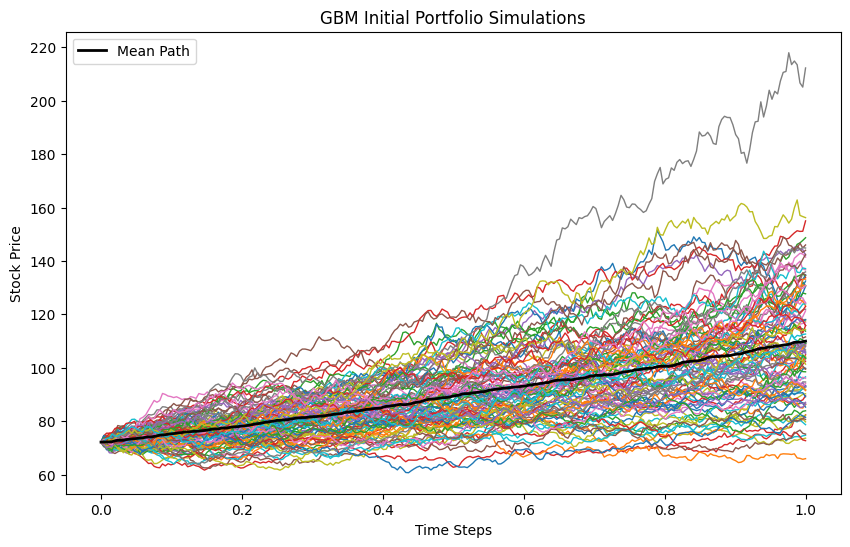

In [7]:
gbm_init_port=dat_func.simulate_gbm_portfolio(returns_df,stock_df,init_weights)
vis.plot_paths(gbm_init_port.iloc[:100],'GBM Initial Portfolio',True)

In [8]:
gbm_ret=(gbm_init_port.mean(axis=0).iloc[-1]-gbm_init_port.mean(axis=0).iloc[0])/gbm_init_port.mean(axis=0).iloc[0]
print(f'GBM Initial Portfolio Return: {round(gbm_ret*100,2)}%')

GBM Initial Portfolio Return: 54.57%


### Merton Jump Diffusion: 

In [9]:
# Estimate the number of jumps, mean jump, and vol of jumps
gpc_lambda_,gpc_m,gpc_v=dat_func.estimate_merton_params(returns_df[ex_stock])

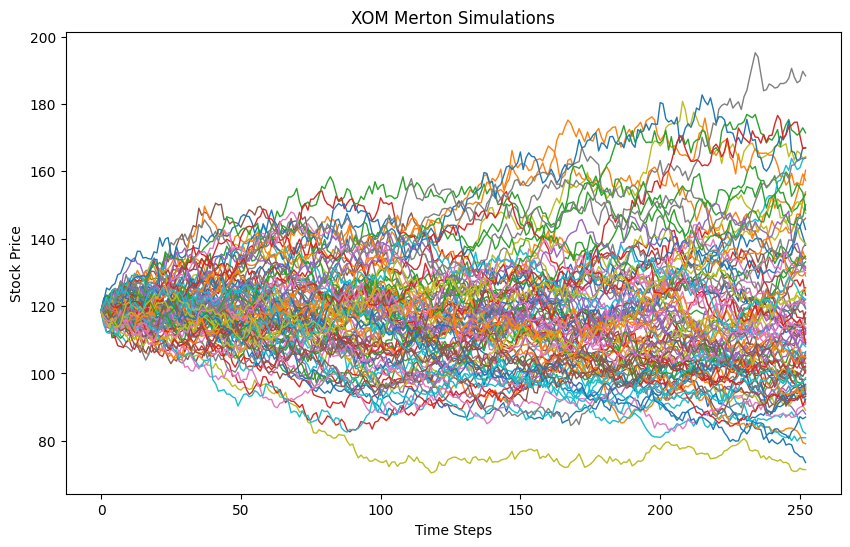

In [10]:
gpc_merton=dat_func.simulate_merton(stock_df[ex_stock][-1],returns_df.mean()[ex_stock]*252,returns_df.std()[ex_stock]*np.sqrt(252),1,gpc_lambda_,gpc_m,gpc_v,1/252,100)
vis.plot_paths(gpc_merton,f'{ex_stock} Merton')

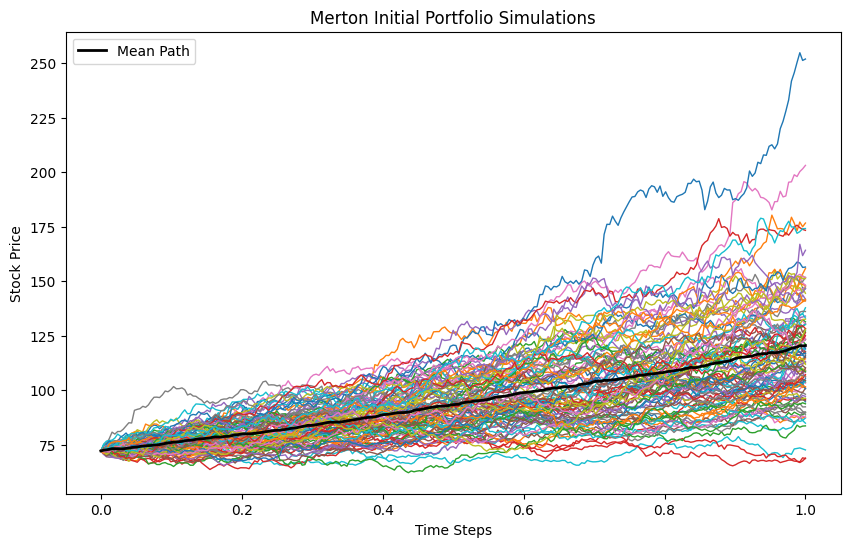

In [11]:
merton_init_port=dat_func.simulate_merton_portfolio(returns_df,stock_df,init_weights)
vis.plot_paths(merton_init_port.iloc[:100],'Merton Initial Portfolio',True)

In [12]:
merton_ret=(merton_init_port.mean(axis=0).iloc[-1]-merton_init_port.mean(axis=0).iloc[0])/merton_init_port.mean(axis=0).iloc[0]
print(f'Merton Initial Portfolio Return: {round(merton_ret*100,2)}%')

Merton Initial Portfolio Return: 66.78%


### Constant Elasticity of Variance (CEV): 

Estimated XOM CEV Parameters: mu=0.00031413808013429795, std=0.00809315254442414, gamma=1.110474297157241


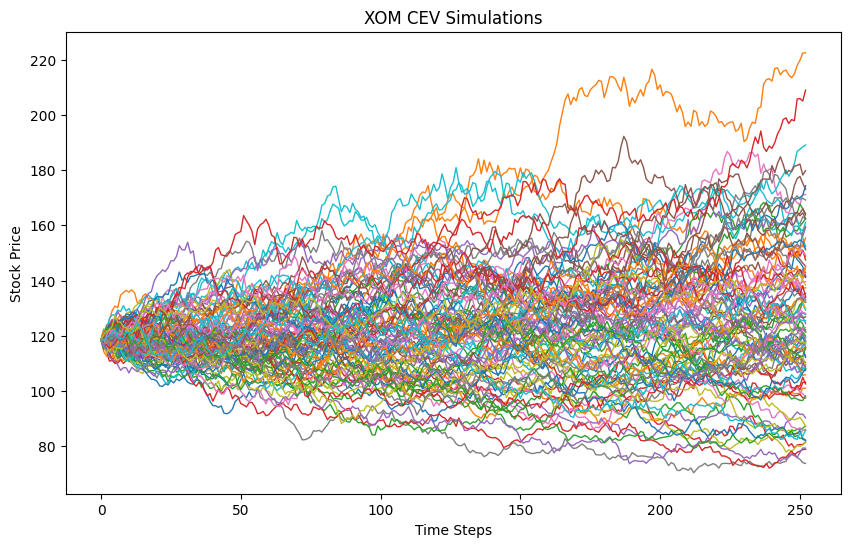

In [13]:
cev_ex_params=dat_func.estimate_cev_params(stock_series=stock_df[ex_stock])
simulated_prices = dat_func.simulate_cev(stock_df[ex_stock][-1],cev_ex_params[0]*252,cev_ex_params[1]*np.sqrt(252), gamma=cev_ex_params[2], T=1)
vis.plot_paths(simulated_prices[:100],f'{ex_stock} CEV')

In [14]:
# cev_init_port=dat_func.simulate_cev_portfolio(stock_df,init_weights)
# vis.plot_paths(cev_init_port.iloc[:100],'CEV Initial Portfolio',True)

In [15]:
# cev_ret=(cev_init_port.mean(axis=0).iloc[-1]-cev_init_port.mean(axis=0).iloc[0])/cev_init_port.mean(axis=0).iloc[0]
# print(f'CEV Initial Portfolio Return: {round(cev_ret*100,2)}%')

### Heston Model:

In [16]:
ex_heston_param=dat_func.estimate_heston_params(ex_stock,end_date,stock_df,risk_free_rate)

Calibrated XOM parameters: theta=0.09914414722148604, kappa=1.6185517312945432, sigma=0.5943699321240737, rho=-0.9999867611430243, v0=0.013670807185855682


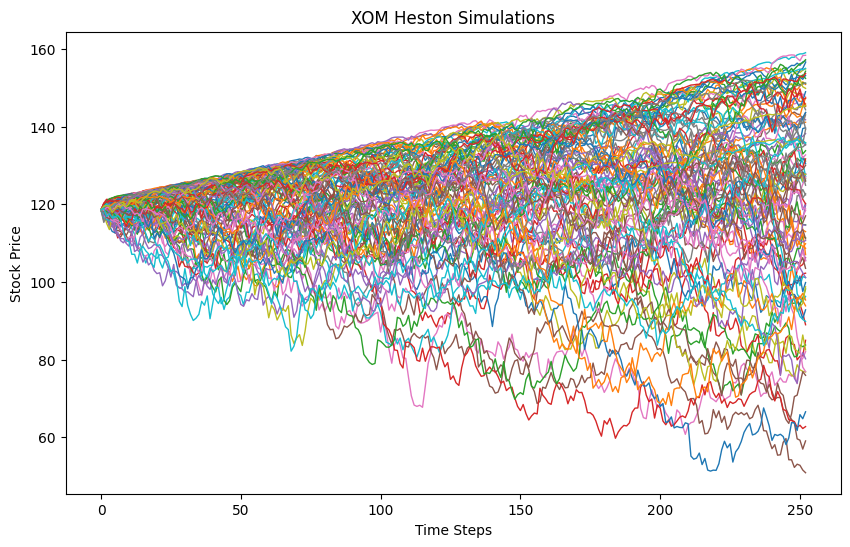

In [17]:
ex_heston_prices=dat_func.simulate_heston(ex_heston_param, stock_df[ex_stock][-1], risk_free_rate)
vis.plot_paths(ex_heston_prices[:100],f'{ex_stock} Heston')

Calibrated ADBE parameters: theta=0.015609918216129351, kappa=0.19031125531871088, sigma=0.8398657389166075, rho=-0.8742133273248018, v0=0.010529623510031332


Calibrated AMAT parameters: theta=0.019737698125580513, kappa=0.1988831567419615, sigma=0.5074339367535836, rho=-0.9462222242221948, v0=0.009966757813814424
Calibrated ATKR parameters: theta=4.445266816149023, kappa=0.12231538390827257, sigma=0.5549089148594777, rho=-0.9999995891360721, v0=0.20266094658745473
Calibrated FI parameters: theta=0.1108594438271424, kappa=2.0244871253616648, sigma=0.6988721862746929, rho=-0.999973177690036, v0=0.010511412427430986
Calibrated GPC parameters: theta=0.024853151046251097, kappa=3.503136678100248e-07, sigma=0.5044353322044032, rho=-0.7470627301549393, v0=0.010206019475928217
Calibrated OXY parameters: theta=0.019972121920068687, kappa=0.20770051595382963, sigma=0.49965540036604655, rho=-0.7497316547790477, v0=0.010950099164420878
Calibrated PM parameters: theta=0.0477487396718105, kappa=3.046057782151859e-05, sigma=1.9387797371222246, rho=-0.8431441209467274, v0=0.02245494731933513
Calibrated STLD parameters: theta=5.598090546082232, kappa=0.0245

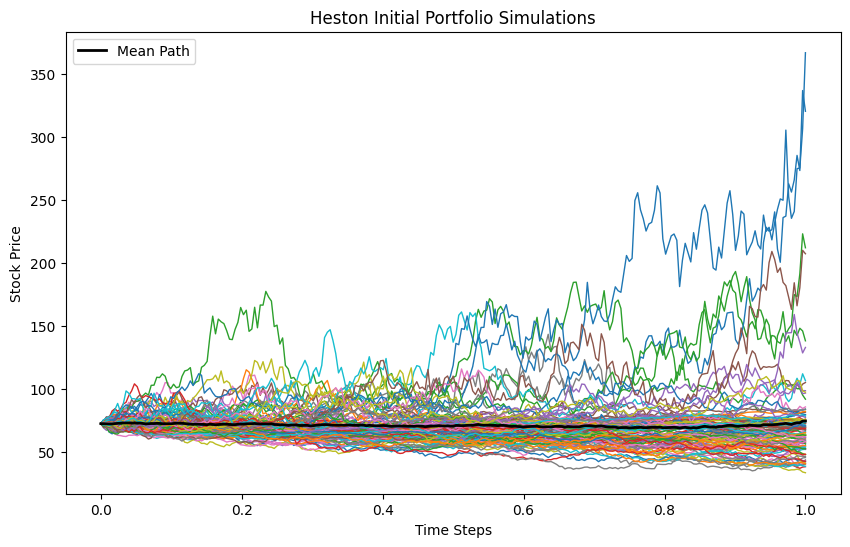

In [18]:
heston_init_port=dat_func.simulate_heston_portfolio(stock_df,init_weights,risk_free_rate)
vis.plot_paths(heston_init_port.iloc[:100],'Heston Initial Portfolio',True)

In [19]:
heston_ret=(heston_init_port.mean(axis=0).iloc[-1]-heston_init_port.mean(axis=0).iloc[0])/heston_init_port.mean(axis=0).iloc[0]
print(f'Heston Initial Portfolio Return: {round(heston_ret*100,2)}%')

Heston Initial Portfolio Return: 3.79%
